In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Load the dataset
data = pd.read_csv('/content/bitcoin.csv')

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

In [5]:
# Feature Engineering
# Add percentage change between Open and Close
data['Pct_Change'] = (data['Close'] - data['Open']) / data['Open']

In [6]:
# Add volatility feature
data['Volatility'] = (data['High'] - data['Low']) / data['Open']

In [7]:
# Add moving averages
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA14'] = data['Close'].rolling(window=14).mean()
data['MA30'] = data['Close'].rolling(window=30).mean()

In [8]:
# Add volume change
data['Volume_Change'] = data['Volume'].pct_change()

In [9]:
# Create target variable: 1 if next day's Close > today's Close, else 0
data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [10]:
# Drop rows with NaN values (due to rolling and shift operations)
data.dropna(inplace=True)

In [11]:
# Split data into features and target
features = ['Pct_Change', 'Volatility', 'MA7', 'MA14', 'MA30', 'Volume_Change']
X = data[features]
y = data['Target']

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [13]:
# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
# Make predictions
y_pred = model.predict(X_test)

In [15]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [16]:
# Output results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Accuracy: 0.47
Confusion Matrix:
 [[242   7]
 [276  12]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.97      0.63       249
           1       0.63      0.04      0.08       288

    accuracy                           0.47       537
   macro avg       0.55      0.51      0.35       537
weighted avg       0.56      0.47      0.33       537



In [17]:
# Save feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
print("Feature Importance:\n", feature_importance)

Feature Importance:
          Feature  Importance
1     Volatility    0.173915
5  Volume_Change    0.170137
0     Pct_Change    0.168732
4           MA30    0.166524
3           MA14    0.161622
2            MA7    0.159070


In [18]:
# Backtesting the strategy
data['Prediction'] = model.predict(X)
data['Strategy_Return'] = data['Prediction'] * data['Pct_Change']

In [19]:
cumulative_strategy_return = (1 + data['Strategy_Return']).cumprod()
cumulative_market_return = (1 + data['Pct_Change']).cumprod()

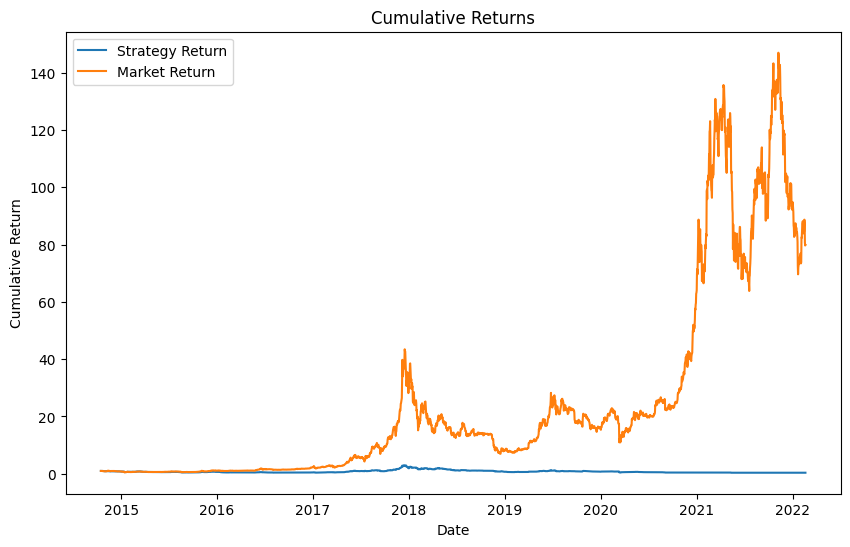

In [20]:
# Plot cumulative returns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], cumulative_strategy_return, label='Strategy Return')
plt.plot(data['Date'], cumulative_market_return, label='Market Return')
plt.legend()
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [ ]:

# Enhanced Feature Engineering
# Adding Exponential Moving Averages (EMA)
data['EMA12'] = data['Close'].ewm(span=12, adjust=False).mean()
data['EMA26'] = data['Close'].ewm(span=26, adjust=False).mean()

# Adding Relative Strength Index (RSI)
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Lagged features
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

# Drop rows with NaN values due to new features
data.dropna(inplace=True)


In [ ]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Interactive Plot: Price and Prediction Signal
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Bitcoin Prices', 'Prediction Signals'))

# Plot price movement
fig.add_trace(go.Scatter(x=data['Date'], y=data['Close'], mode='lines', name='Close Price'), row=1, col=1)

# Highlight buy signals
buy_signals = data[data['Prediction'] == 1]
fig.add_trace(go.Scatter(x=buy_signals['Date'], y=buy_signals['Close'], mode='markers', name='Buy Signal', marker=dict(color='green', size=8)), row=1, col=1)

# Cumulative returns
cumulative_returns = (1 + data['Strategy_Return']).cumprod()
fig.add_trace(go.Scatter(x=data['Date'], y=cumulative_returns, mode='lines', name='Cumulative Returns'), row=2, col=1)

# Update layout
fig.update_layout(height=800, width=1000, title='Bitcoin Price and Strategy Performance', showlegend=True)
fig.show()


In [ ]:

from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print('Best Parameters:', grid_search.best_params_)

# Update the model with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
